# Test mapping of cloud depth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap
import astropy.units as u

## First load all the files

In [3]:
from maplib import get_wavel, cloud_depth, stringy, load_out3

In [4]:
file_root = 'static_weather_results/HATP_7b'

In [5]:
lons  = np.arange(-180., 180.01, 15) # deg
lats  = np.arange(0., 67.51, 22.5) # deg
nprof = len(lons) * len(lats) # number of (lon, lat) profiles

In [6]:
# Get the wavelengths of interest. Assume all files are the same
wavel_file = file_root + '_Phi{}Theta{}/out3_extinction.dat'.format(stringy(lons[0]), stringy(lats[0]))
wavel = get_wavel(wavel_file) # um

In [7]:
P_UNIT = u.dyne / (u.cm**2)
P_CONVERT = P_UNIT.to(u.bar)

pmin, pmax = 1.e-6, 1.e3

print(P_CONVERT)

1e-06


In [8]:
# Read in the cloud depth values for each file.
# Make a 3D array with dimensions (lon, lat, wavel)
NLO, NLA, NWA = len(lons), len(lats), len(wavel)
Z = np.zeros((NLO, NLA, NWA))
for i in range(NLO):
    for j in range(NLA):
        w, d = cloud_depth(stringy(lons[i]), stringy(lats[j]), p_val=True)
        Z[i,j,:] = d * P_CONVERT

# The 180 longitude is same as -180
#Z[0,:,:] = Z[-1,:,:]

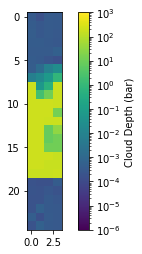

In [9]:
# rough sketch of where we are using imshow
im = Z[:,:,20]
plt.imshow(im, norm=LogNorm(), vmin=pmin, vmax=pmax)
plt.colorbar(label='Cloud Depth (bar)')

In [10]:
np.mean(Z[:,:,30] - Z[:,:,0])

12.7180111267731

## Try out basemap

In [11]:
X, Y = np.meshgrid(lons,lats)

Text(0.5, 1.0, 'HAT-P-7b, 1.0 $\\mu$m')

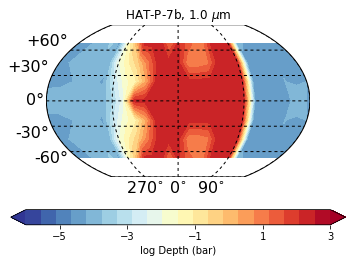

In [12]:
fig = plt.figure()
ax  = plt.subplot(111)
m = Basemap(projection='kav7',lon_0=0,resolution=None)

nlev = 21
#levels = np.logspace(-6, 3, nlev)
levels = np.linspace(-6, 3, nlev)

cmap = plt.cm.RdYlBu_r

iw = 10
CS = m.contourf(X, Y, np.log10(Z[:,:,iw].T), levels=levels, 
                extend='both', cmap=cmap, latlon=True)

# mirror southern-hemisphere
CS = m.contourf(X, -Y, np.log10(Z[:,:,iw].T), levels=levels, 
                extend='both', cmap=cmap, latlon=True)

def fmtfunc(inlon):
        string = r'{:g}'.format(inlon)+r'$^{\circ}$'
        #print string                                                                                                   
        return string

meridians = np.arange(0., 360., 90)
m.drawmeridians(meridians, labels=[False,False,False,True],
                    labelstyle=None, fmt=fmtfunc, dashes=[3,3], color='k', fontsize=16)
parallels = np.arange(-90., 90, 30)
m.drawparallels(parallels, labels=[True,False,False,False],
                    labelstyle='+/-', dashes=[3,3], color='k',fontsize=16)

labels = ['{:.1f}'.format(x) for x in levels[::3]]

plt.colorbar(label='log Depth (bar)', ticks=np.arange(-5, 4)[::2], orientation='horizontal')
plt.title('HAT-P-7b, {:.1f} $\mu$m'.format(wavel[iw]))

In [13]:
print(levels)

[-6.   -5.55 -5.1  -4.65 -4.2  -3.75 -3.3  -2.85 -2.4  -1.95 -1.5  -1.05
 -0.6  -0.15  0.3   0.75  1.2   1.65  2.1   2.55  3.  ]


# Test the python script

In [15]:
import map_cloud_depth as mcd

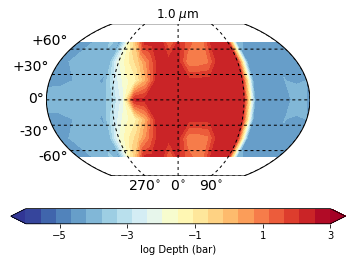

In [16]:
test = mcd.map_cloud_depth(10)

In [17]:
mcd.Z.shape

(25, 4, 31)

In [18]:
Z.shape

(25, 4, 31)

In [19]:
np.sum(mcd.Z - Z)

0.0

## Make a widget

Need to have ipywidgets installed. I recommend using

`conda install -c conda-forge ipywidgets`

In [20]:
import ipywidgets as widgets
from ipywidgets import interact

In [21]:
def widget_map(i):
    result = mcd.map_cloud_depth(i)
    return

In [22]:
w = widgets.IntSlider(10, min=0, max=len(wavel)-1, continuous_update=False)
interact(widget_map, i=w)

interactive(children=(IntSlider(value=10, continuous_update=False, description='i', max=30), Output()), _dom_c…

<function __main__.widget_map(i)>

## Look at vertical extinction profile

In [23]:
from maplib import get_ext_data

In [24]:
# A random example sight line (that has clouds)
z, dtau_dz = load_out3('extinction', lons[6], lats[0])
dust   = load_out3('dust', lons[6], lats[0])
thermo = load_out3('thermo', lons[6], lats[0])

rho_d = dust['rhod/rho'] * thermo['rho']

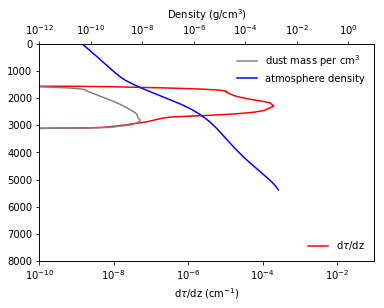

In [25]:
i = 10
ax = plt.subplot(111)
ax.plot(dtau_dz[:,i], z*1.e-5, color='r', label=r'd$\tau$/dz')
ax.set_ylim(8000, 0)
ax.set_xscale('log')
ax.set_xlim(1.e-10, 0.1)
ax.set_xlabel(r'd$\tau$/dz (cm$^{-1}$)')
plt.legend(loc='lower right', frameon=False)

ax1 = ax.twiny()
ax1.plot(rho_d, z*1.e-5, color='0.5', label='dust mass per cm$^3$')
ax1.set_xscale('log')
ax1.plot(thermo['rho'], z*1.e-5, color='b', label='atmosphere density')
ax1.set_xlim(1.e-12, 10)
ax1.set_xlabel('Density (g/cm$^3$)')

plt.legend(loc='upper right', frameon=False)